In [1]:
# Import everything needed

import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

In [2]:
total_data = pd.read_csv("cleaned_data.dbcan_cog_HGT.tsv", sep="\t")

In [3]:
total_data.head()

,Unnamed: 0,taxonID,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,Horizontally_Transferred_%
0,0,2511231155,Acinetobacter,NPA,NPA,0.000252,0.0,0.000000,0.000252,0.000252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
1,1,2519103115,Acinetobacter,NPA,NPA,0.000265,0.0,0.000265,0.000265,0.000265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27
2,2,2519899735,Acinetobacter,NPA,NPA,0.000262,0.0,0.000262,0.000262,0.000262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
3,3,2526164562,Acinetobacter,NPA,NPA,0.000495,0.0,0.000000,0.000248,0.000248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.16
4,4,2529293005,Acinetobacter,NPA,NPA,0.000263,0.0,0.000263,0.000263,0.000263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45


In [4]:
# Removing soil! Separating PA and NPA!

df = total_data[total_data["Classification"] != "soil"]
print(df.shape)
df.head()

df_PA = df[df["Classification"] == "PA"]
df_NPA = df[df["Classification"] == "NPA"]

X_PA = df_PA.drop(columns = ['Unnamed: 0','Order','taxonID','Classification','Root_info'])
y_PA = df_PA["Classification"]

X_NPA = df_NPA.drop(columns = ['Unnamed: 0','Order','taxonID','Classification','Root_info'])
y_NPA = df_NPA["Classification"]

df_all = pd.concat([X_PA, X_NPA])
y_all = pd.concat([y_PA, y_NPA])

(3261, 4565)


In [5]:
# Data Preprocessing

In [6]:
# Splitting test and train dataset to keep PA/NPA ratio intact.

X_PA_train, X_PA_test, y_PA_train, y_PA_test = train_test_split(X_PA, y_PA, test_size=0.33, random_state=42)
X_NPA_train, X_NPA_test, y_NPA_train, y_NPA_test = train_test_split(X_NPA, y_NPA, test_size=0.33, random_state=42)

In [7]:
# Combine training data, and test data

X_train = pd.concat([X_PA_train, X_NPA_train])
y_train = pd.concat([y_PA_train, y_NPA_train])

X_test = pd.concat([X_PA_test, X_NPA_test])
y_test = pd.concat([y_PA_test, y_NPA_test])

# Scale the data to preprocess it
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

X_train = sklearn.preprocessing.maxabs_scale(X_train)
X_test = sklearn.preprocessing.maxabs_scale(X_test)

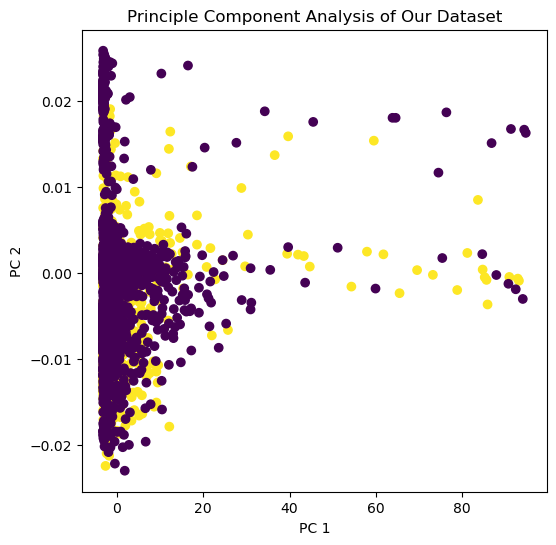

In [8]:
# Principal Components Analysis

pca = decomposition.PCA(n_components=2)

pca_result = pca.fit_transform(df_all)

# Making labels for plotting the graph

labels = y_all.ravel()

for idx, val in enumerate(labels):
    if val == "NPA":
        labels[idx] = 0
    elif val == "PA":
        labels[idx] = 1
    else:
        print("Error!")

x = pca_result[:,0]
y = pca_result[:,1]
plt.figure(figsize=(6, 6))
plt.scatter(x,y, c = labels)

pca_result = pd.DataFrame(pca_result)
    
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Principle Component Analysis of Our Dataset")
plt.savefig("PCA_All_RAPs.svg")
plt.show()

In [9]:
# Train Logistic Regression Model - 3 Versions

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

clf = LogisticRegression(random_state=42, max_iter = 500, penalty = 'l2').fit(X_train, y_train)

In [10]:
clf2 = LogisticRegression(random_state=42, max_iter = 5000, penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5).fit(X_train, y_train)

In [11]:
clf3 = LogisticRegression(random_state=42, max_iter = 5000, penalty = 'l1', solver = 'saga').fit(X_train, y_train)

In [12]:
y_pred_1 = clf.predict_proba(X_test)
y_pred_2 = clf2.predict_proba(X_test)
y_pred_3 = clf3.predict_proba(X_test)

In [13]:
clf.score(X_train, y_train)

0.9967948717948718

In [14]:
clf2.score(X_train, y_train)

0.9839743589743589

In [15]:
clf3.score(X_train, y_train)

0.972985347985348

In [16]:
clf.score(X_test, y_test)

0.9062209842154132

In [17]:
clf2.score(X_test, y_test)

0.9099350046425255

In [18]:
clf3.score(X_test, y_test)

0.8941504178272981

In [19]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, y_pred_1[:,0], pos_label = ["NPA"])
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test, y_pred_2[:,0], pos_label = ["NPA"])
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_test, y_pred_3[:,0], pos_label = ["NPA"])

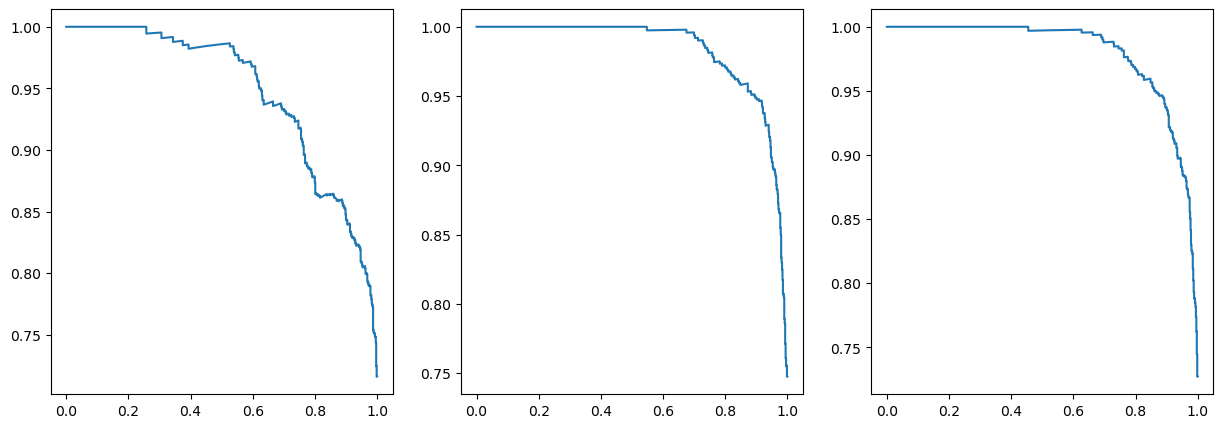

In [35]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].plot(recall_1, precision_1)
ax[0].set_title = ('L2 Norm')
ax[1].plot(recall_2, precision_2)
ax[1].set_title = ('Elastic Net')
ax[1].set_xlabel = ('Recall')
ax[1].set_ylabel= ('Precision')
ax[2].plot(recall_3, precision_3)
ax[2].set_title = ('L1 Norm')
ax[2].set_xlabel = ('Recall')
ax[2].set_ylabel = ('Precision')

[]

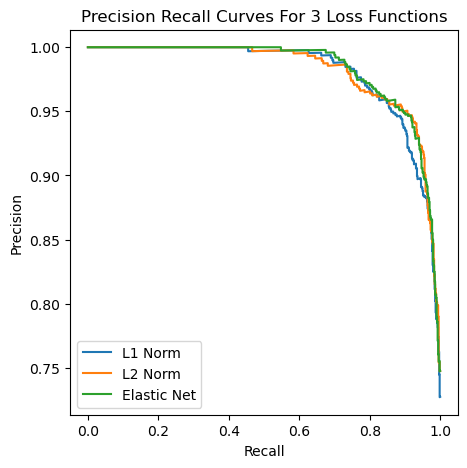

In [21]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_3, precision_3)
ax.plot(recall_1, precision_1)
ax.plot(recall_2, precision_2)
ax.legend(['L1 Norm', 'L2 Norm', 'Elastic Net'])
ax.set_title('Precision Recall Curves For 3 Loss Functions')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

In [22]:
# Support Vector Machine Classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

clf = SVC(gamma = 'auto', probability = True).fit(X_train, y_train)

In [23]:
clf.score(X_train, y_train)

0.8278388278388278

In [24]:
clf.score(X_test, y_test)

0.8133704735376045

In [25]:
y_pred_1 = clf.predict_proba(X_test)

In [26]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, y_pred_1[:,0], pos_label = 'NPA')

[]

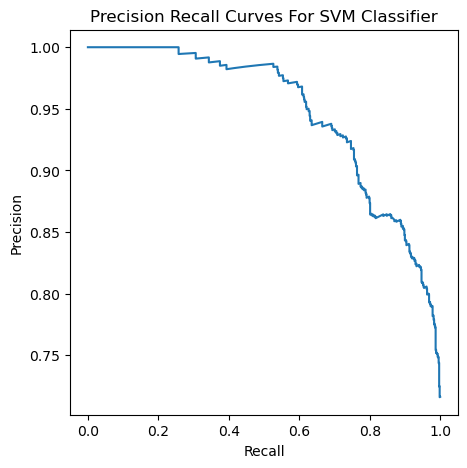

In [27]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_1, precision_1)
ax.set_title('Precision Recall Curves For SVM Classifier')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

In [28]:
# Gaussian Naive Bayes Classifier
# https://scikit-learn.org/stable/modules/naive_bayes.html

gnb = GaussianNB().fit(X_train,y_train)

In [29]:
y_pred = gnb.predict_proba(X_test)

In [30]:
gnb.score(X_train,y_train)

0.8017399267399268

In [31]:
gnb.score(X_test,y_test)

0.8040854224698236

In [32]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, y_pred_1[:,0], pos_label = 'NPA')

[]

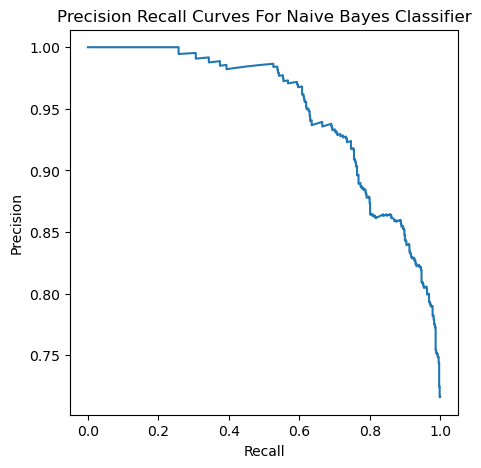

In [33]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_1, precision_1)
ax.set_title('Precision Recall Curves For Naive Bayes Classifier')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

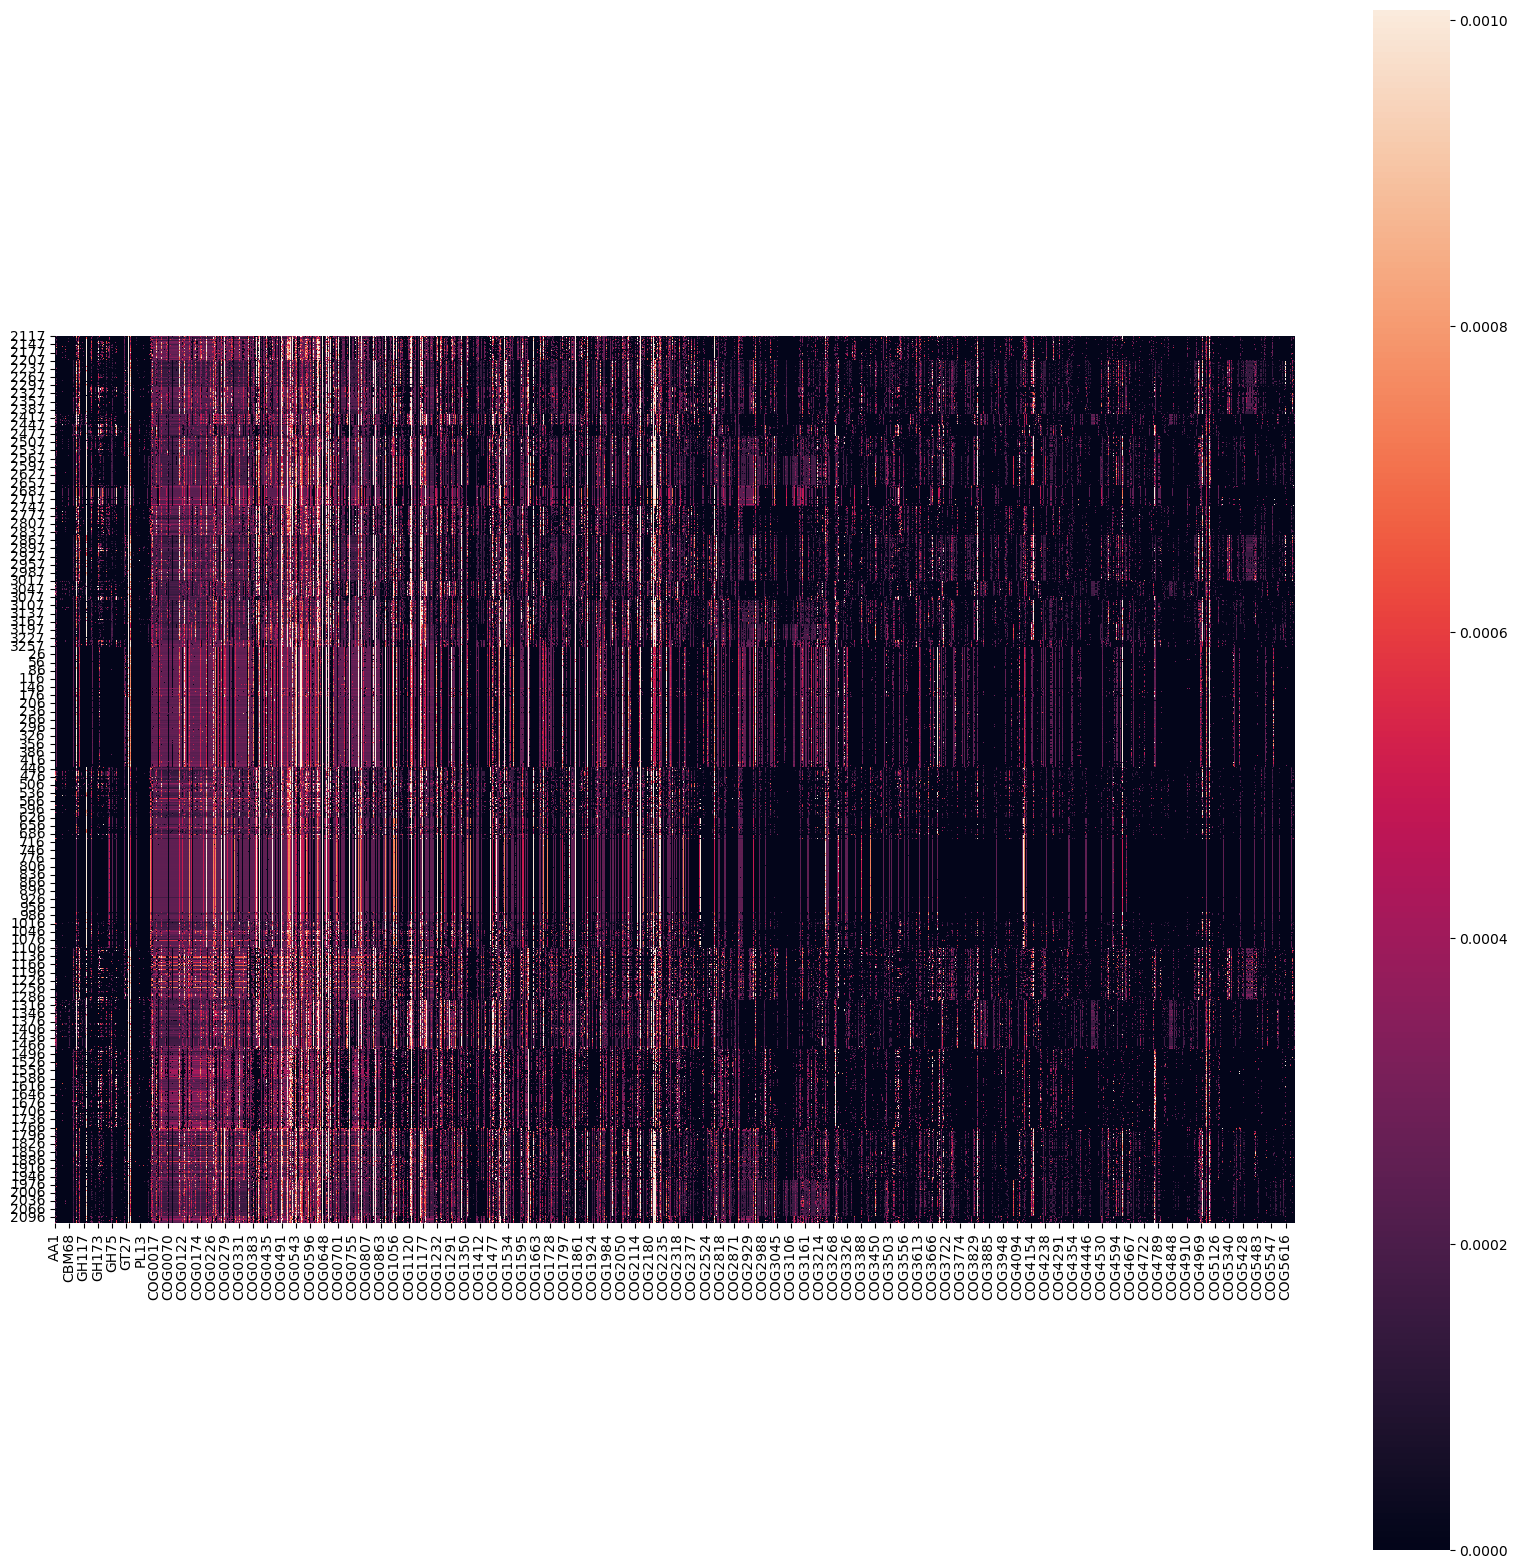

In [36]:
fig, ax = plt.subplots(figsize=(20,20))     
ax = sb.heatmap(df_all, square = True, robust = True)